In [1]:
# | default_exp data_modeling

# Data Modeling

> In this section, we will set up our model.


In [2]:
# |export
import pandas as pd
import torch
from torch.utils.data import Dataset
from fastai.tabular.all import *
from ML_Task.data_preprocessing import *
from nbdev.showdoc import *

# Load Data

In [3]:
# train dataset path
path_train = "./Data/facebook_train.csv"
# test dataset path
path_test = "./Data/facebook_test_no_target.csv"
# train data
Xy_train = load_data(path_train)
# test data
X_test = load_data(path_test)

In [4]:
Xy_train.head()

,CampaignTitle,Sector,Results,Coverage,Impressions,USD spent,StartDate,EndDate,Objetive
0,Liberta Voyages - Engagement avec une publication de Page,Travel,214,1296,1328,1.45,2018-11-09,2018-11-17,Interaction
1,Liberta Voyages - Engagement avec une publication de Page,Travel,931,4220,4299,1.22,2018-11-09,2018-11-17,Interaction
2,Publication : ‎« ‎الحمد لله و الصلاة و السلام على رسول الله.‎ »‎,Travel,120,32321,46095,15.98,2018-12-06,2018-12-11,Messages
3,Publication : ‎« ‎ليبرتا تجمّد الأسعار للموسم الثاني على التوالي‎ »‎,Travel,195,54121,80225,20.00,2018-12-06,2018-12-11,Messages
4,[09/11/2018] Promotion de Testour,Travel,520,15340,28771,7.73,2018-12-07,2018-12-11,Mentions J’aime une Page


# Data Modeling Class

In [5]:
# |export
class DataModeling:
    def __init__(self):
        # data transformer
        self.transformer = TransformCampaign()
        # device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # train data
        self.data = None

    def data_loaders(self, train_data, n_split):
        """
          setting up dataloaders to split data into validation and train

        Parameters
        ----------
        train_data: pd.DataFrame
            train data
        n_splits: int
            validation set ratio

        Returns
        -------
        dls, X: list

        """
        X_ = train_data.copy()
        # clean and transform data
        X_ = self.transformer.fit_transform(X_)
        # splits data between train/validation (n_split for validation) randomly.
        splits = RandomSplitter(n_split, seed=42)(X_)
        # indep variables
        cont_names = [
            var
            for var in X_.columns
            if var not in ["CampaignTitle", "Results", "Coverage", "Impressions"]
        ]
        # create a dataloader using fastai tabularPandas
        # we specify data, splits(train and validation data),
        # continuous columns
        # target values (here we have 3 outputs: Results,Coverage,Impressions)
        # y_block : the task which we want to perform , here we want regression
        # we can also use gpu if it exists
        dls = TabularPandas(
            X_,
            splits=splits,
            procs=[Normalize],
            cont_names=cont_names,
            y_names=["Results", "Coverage", "Impressions"],
            y_block=RegressionBlock(3),
            device=self.device,
        ).dataloaders(patch=".")
        return dls, X_

    @staticmethod
    def find_best_lr(learner, algos):
        """
          find the best learning rate

        Parameters
        ----------
        learner: fastai.tabular.learner.TabularLearner
            fastai learner model
        algos: list
            optimization algorithms to find the best learning rate

        Returns
        -------
        lr: float

        """
        # find the best learning rate by specifing some optimization algorithms
        lr = learner.lr_find(suggest_funcs=algos)
        return lr

    def train(
        self, train_data, layers, n_epochs, n_splits, lr_algos, metrics, n_outputs
    ):
        """
          training phase to fit the model

        Parameters
        ----------
        train_data: pd.DataFrame
            train data
        layers: list
            model layers
        n_epochs: int
            the number of complete passes through the training dataset.
        n_splits: int
            validation set ratio
        lr_algos: list
            optimization algorithms to find the best learning rate
        metrics: list
            a list of metrics to assess the model
        n_outputs: int
            the number of model outputs

        Returns
        -------
        learner: fastai.tabular.learner.TabularLearner

        """
        X_ = train_data.copy()
        # get dataloaders
        dls, X_ = self.data_loaders(X_, n_splits)
        self.data = X_
        # specify outputs range
        # min range
        mins = [
            X_.Results.min(),
            X_.Coverage.min(),
            X_.Impressions.min(),
        ]
        # max range
        maxs = [
            X_.Results.max(),
            X_.Coverage.max(),
            X_.Impressions.max(),
        ]
        # outputs range
        y_range = (
            torch.tensor(mins).to(self.device),
            torch.tensor(maxs).to(self.device),
        )
        # setting up a fastai learner which will implement a Neural Network
        # with 2 layer and 10 neurons in each one.
        # 3 outputs (target values)
        # using 4 metrics to assess the model
        learner = tabular_learner(
            dls,  # dataloaders
            metrics=metrics,  # metrics
            layers=layers,
            n_out=n_outputs,
            y_range=y_range,
        )
        # find the best learning rate
        lr = DataModeling.find_best_lr(learner, lr_algos)
        # to find the best learning rate, we usually pick a value between valley and slide values
        lr = (lr.valley + lr.slide) / 2
        # fit data
        learner.fit(n_epochs, lr=lr, cbs=[ShowGraphCallback()])

        return learner

    def test(self, test_data, learner):
        """
          predict outputs using unseen data

        Parameters
        ----------
        test_data: pd.DataFrame
            test data
        learner: fastai.tabular.learner.TabularLearner
            model

        Returns
        -------
        output: pd.DataFrame

        """
        X_ = test_data.copy()
        # transform test data
        X_ = self.transformer.transform(X_, data_type="test")
        # test dataloader
        test_dl = learner.dls.test_dl(X_)
        # predict outputs
        preds, _ = learner.get_preds(dl=test_dl)
        preds = pd.DataFrame(
            preds, index=X_.index, columns=["results", "coverage", "impressions"]
        )
        # output
        output = pd.concat([test_data, preds], axis=1)
        # Target values rescalling
        # results
        output["results"] = np.exp2(output.results) * output["USD spent"]
        # coverage
        output["coverage"] = np.exp2(output.coverage) * output["USD spent"]
        # impressions
        output["impressions"] = np.exp2(output.impressions) * output["USD spent"]

        return output

    @staticmethod
    def evaluate(train_output, test_output):
        """
          evaluate test outputs

        Parameters
        ----------
        train_data: pd.DataFrame
            train data
        test_data: pd.DataFrame
            test data

        Returns
        -------
        train_agg, test_agg: pd.DataFrame, pd.DataFrame

        """
        # aggregate train data by sector
        train_agg = train_output.groupby(["Sector"]).agg(
            {"Results": "mean", "Coverage": "mean", "Impressions": "mean"}
        )
        # aggregate test data by sector
        test_agg = preds.groupby(["Sector"]).agg(
            {"results": "mean", "coverage": "mean", "impressions": "mean"}
        )
        # return
        return train_agg, test_agg

    @staticmethod
    def export(learner, model_class, path_class, path_model):
        """
          save models

        Parameters
        ----------
        learner: fastai.tabular.learner.TabularLearner
            fitted model
        model_class: __main__.DataModeling
            model class instance
        path_class: str
            class path
        path_model: str
            model path

        Returns
        -------
        None

        """
        # save model
        learner.export(path_model)
        # save class instance
        torch.save(model_class, path_class)

In [6]:
model = DataModeling()

Using the stochastic gradient descent optimization algorithm, neural networks are trained. Since back propagation is used to determine the error gradient for the model's present state in stochastic gradient descent, we now have a mathematically proper understanding of how adjusting weights affect model performance.\
The learning rate, which is a predetermined step-size, is used to update the model's weights based on the error gradient. In other words, learning rate is a variable that determines how much to adjust the model each time the model weights are updated to account for the predicted error.
With fastai we can use multiple algorithms that can help to determine the best learning rate, like minimum, steep, valley, slide.\
Note: We discovered that Valley is typically selected above Slide, Steep, and Minimum based on the fastai documents.

We have established certain metrics for our model in order to evaluate the model's performance:

- MSE  : Mean Squared Error = $\frac{1}{n} \sum \limits _{i=1} ^ {n} (real Value - predcited Value)^{2}$
- RMSE : Root Mean Squared Error = $\sqrt {MSE}$
- MAE  : Mean Absolute Error = $\frac{1}{n} \sum \limits _{i=1} ^ {n} |real Value - predcited Value|$

epoch,train_loss,valid_loss,mse,_rmse,mae,time
0,4.957641,4.665702,4.665702,2.160024,1.669009,00:00
1,3.879986,2.925579,2.925579,1.710432,1.246833,00:00
2,3.142403,2.627235,2.627235,1.620875,1.196710,00:00
3,2.654737,1.893560,1.893560,1.376067,1.016707,00:00
4,2.343770,1.540481,1.540481,1.241161,0.925708,00:00
5,2.137447,1.468104,1.468104,1.211653,0.908179,00:00
6,1.970889,1.446457,1.446457,1.202688,0.898828,00:00
7,1.838005,1.359755,1.359755,1.166085,0.877331,00:00
8,1.745457,1.363112,1.363112,1.167524,0.882658,00:00
9,1.671369,1.466601,1.466601,1.211033,0.907693,00:00


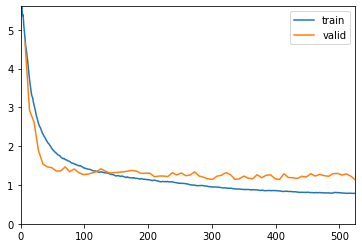

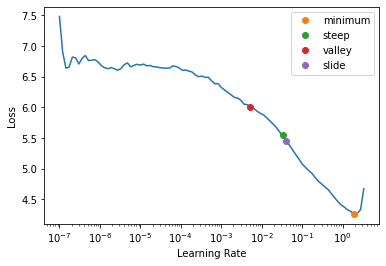

In [7]:
learner = model.train(Xy_train,[200,75,5,3],75,0.3,(minimum, steep, valley, slide),[mse, rmse, mae],3)

Export learner and model class

In [8]:
DataModeling.export(learner, model, "./models/model.pt", "./models/learner.pkt")

# predictions with Test Data

After the training phase, we are going to use our model to predict unseen data (test dataset)

In [9]:
learner = load_learner("./models/learner.pkt")
model = torch.load("./models/model.pt")
preds = model.test(X_test, learner)

In [10]:
model.data

,Results,Coverage,Impressions,USD spent,duration,Holidays,NumberOfWeekends,Sector_Automotive,Sector_B2B,Sector_Ecommerce & Retail,...,Objetive_Messages,Objetive_Trafic,Season_autumn-autumn,Season_autumn-winter,Season_spring-spring,Season_spring-summer,Season_summer-autumn,Season_summer-summer,Season_winter-spring,Season_winter-winter
2,2.908695,10.981989,11.494127,15.98,5,0,2,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.285402,11.401973,11.969836,20.00,5,0,2,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.071899,10.954542,11.861859,7.73,4,0,2,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5.605130,10.104277,10.779776,64.94,12,0,4,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2.219358,11.191053,11.278774,4.08,1,0,0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,5.901457,10.507064,11.254659,21.28,3,0,2,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
883,5.505464,9.937925,10.541326,32.47,4,0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
885,0.005420,9.397469,9.725237,7.97,0,0,0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
886,0.080766,9.510754,9.868578,17.02,1,0,0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Fixing a benchmark to compare against is necessary in order to assess our model. To do this, we will average each output across all the sectors in our dataset.
We can judge a model to be acceptable if its outputs closely resemble those obtained during training.

In [11]:
train, test = model.evaluate(Xy_train, preds)

In [12]:
train

,Results,Coverage,Impressions
Sector,,,
Automotive,16145.196429,94148.660714,306935.696429
B2B,83.807692,33666.596154,90949.365385
Ecommerce & Retail,2689.225859,48622.265139,132279.265139
Travel,5662.946746,89106.230769,199116.514793


In [13]:
test

,results,coverage,impressions
Sector,,,
Automotive,2174.601057,48469.332482,85069.554028
B2B,158.634038,46260.655589,95435.294149
Ecommerce & Retail,837.453714,52073.836274,101124.304690
Travel,3370.051552,91679.891653,155464.350941
